# KerasによるMNIST画像分類チュートリアル

## 概要
このノートではMNISTという手書き文字のデータセットに対して、0から9までの数字の画像とその答えが入っていて、この画像を分類するための特徴をつかむためにディープラーニングをする。

In [1]:
## development environment
# keras=2.1.2
# tensorflow=1.4.1
# dask=0.16.1
import keras
import tensorflow as tf
import dask
import warnings
warnings.filterwarnings('ignore')

print("keras={}".format(keras.__version__))
print("tensorflow={}".format(tf.__version__))
print("dask={}".format(dask.__version__))

/Users/Kakutofu/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/Kakutofu/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


keras=2.1.2
tensorflow=1.4.1
dask=0.16.1


## モジュールのインポート

In [2]:
# coding=utf8
import numpy as np
np.random.seed(98) # シード値の保持

from keras.models import Sequential
from keras.layers import Dense

## MNISTデータの読み込み

In [3]:
# MNISTの手書き文字データのインポート
from keras.datasets import mnist

In [4]:
#  Xは画像データ，yは画像データのラベル(0から9)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## MNISTデータの前処理

入力する画像の次元数(ここで言う次元数って言うのは行列の数をイメージするとわかりやすいかも)  
28 * 28 次元って言うのは，縦28ピクセル，横28ピクセルの画像を扱っているっていうイメージでok．

In [5]:
img_rows, img_cols = 28,28

画像は0から255までの数字を使って白黒で表現されているので，ここでは値を大きくしないために255で割ってあげて，白黒表現を0から1の間で表現している．なので型もintではなくfloatにする必要がある

In [6]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [7]:
nb_classes = 10 # 正解のパターン数

学習用の画像データのラベルは0から9までの数字で表現されていた．ここでは画像を機械学習して分類をしたいので，ただ数字で表すのではなく正解のパターンのなかのどこになるのかを表現する必要があるので，クラスベクトルをバイナリクラスの行列に変換している．

In [8]:
from keras.utils import np_utils

In [9]:
# クラスベクトルをバイナリクラスの行列に変換する
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [10]:
# クラスベクトル(ここでは一枚目の正解値は5)
y_train[0]

5

In [11]:
# バイナリクラスの行列(10個ある正解パターンの中の6番目(0から数えて))
# 上も下もどちらも正解値は５を示している．
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [12]:
# backendの違いによる次元数の入力型の調整(おまじない)
from keras import backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
X_train.shape # 60000枚の画像データが28 * 28 ピクセルで準備されている

(60000, 28, 28, 1)

In [14]:
Y_train.shape # 60000個のラベルデータ

(60000, 10)

## モデルの構築

### 畳み込みニューラルネット

画像は入力情報によって位置や形は違っても近くの場所に同じ特徴が存在したりすることがある，全結合ニューラルネットでは１ピクセルごとに判定をしてしまっているため精度にやや不安があった．  
１ピクセルで判定せずある程度の領域を圧縮して１ピクセルとして扱えば，画像それぞれの似た特徴というのを捉えやすくなるという主張をもったアルゴリズムが畳み込みニューラルネットである．
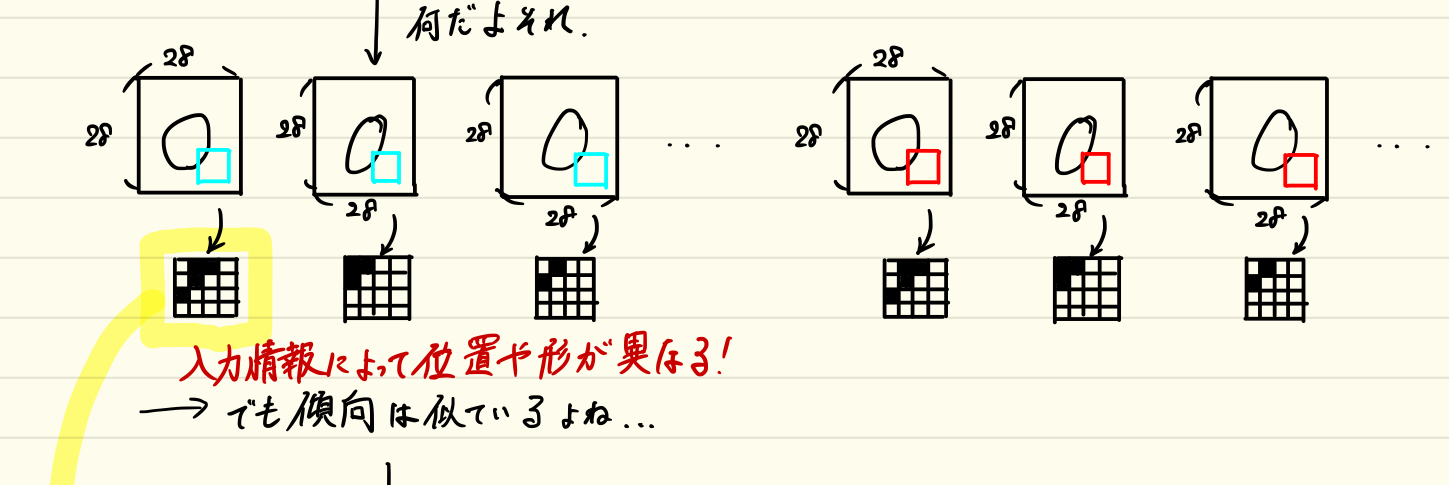

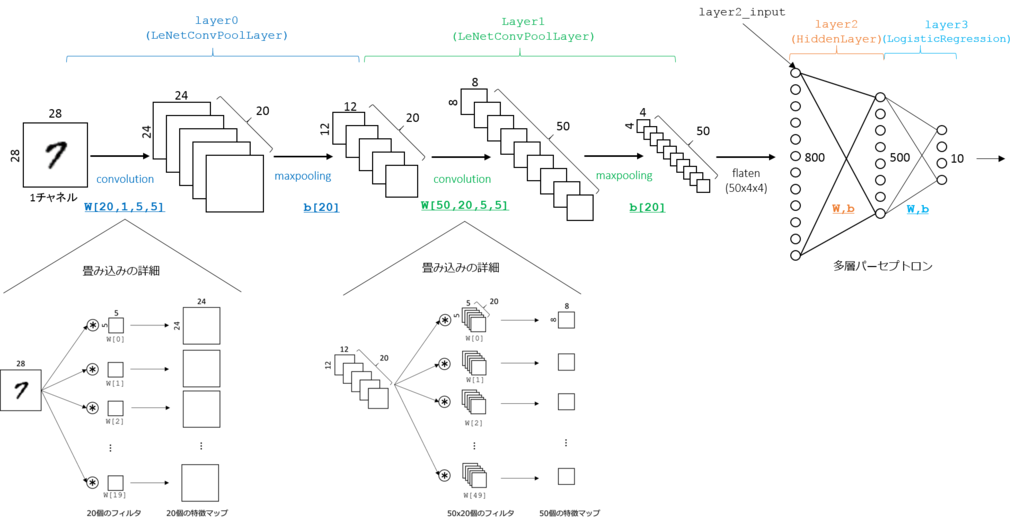

In [15]:
from keras.layers import Dropout,Flatten,Conv2D,MaxPooling2D

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # 学習するにあたって25%のパーセプトロンを使用しない(これにより過学習(学習データに特化することを防いでいる)
model.add(Flatten()) # Flattenによってこれまで画像で学習していたものをこれまでの1*n次元の形に変換している．
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## モデルのコンパイル

In [18]:
from keras.optimizers import SGD, Adadelta # 最適化手法(確率的勾配降下法,Adadelta)

# モデルのコンパイル
model.compile(loss="categorical_crossentropy", # 誤差(損失)関数
             # optimizer="sgd",
             optimizer="Adadelta", # 急速かつ単調な学習率の低下を防ぐ手段を探る最適化関数
             metrics=['accuracy'] # 評価指標
             )

## モデルの保存とパラメータの保存

In [19]:
# JSON形式でモデルを保存
json_string = model.to_json()
#open('./keras_mlp.json', 'w').write(json_string)
open('./cifar10_cnn.json', 'w').write(json_string)

2781

In [20]:
#　初期ウエイトの保存
model.save_weights('./cifar10_cnn_init_weight.hdf5', overwrite=True)

## モデルの読み出しとパラメータの呼び出し

In [21]:
#from keras.models import model_from_json, model_from_yaml

In [22]:
# JSON形式で保存されたモデルの呼び出し
#json_string = open('./keras_mlp.json', 'r').read()
#model = model_from_json(json_string)

In [23]:
#model.load_weights('./mnist_cnn_best_weight.hdf5')

## MNISTデータの可視化

In [24]:
# 可視化用ライブラリの読み込み
%matplotlib inline
import matplotlib.pyplot as plt

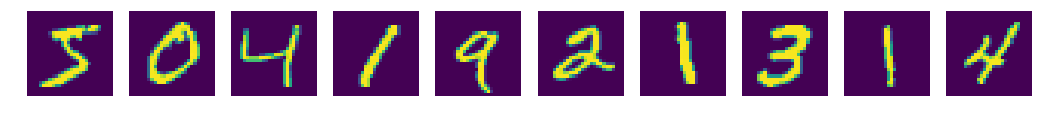

In [25]:
# 入力データを可視化（最初の５文字）
fig, ax = plt.subplots(1, 10, figsize=(18,8))

for ii in range(10):
    ax[ii].imshow(X_train[ii].reshape(28,28))
    ax[ii].axis('off')

## 学習
+ tensorboard --logdir=/tmp/keras_cnn
+ http://0.0.0.0:6006

In [26]:
# TensorBoardで学習の進捗状況をみる
tb_cb = keras.callbacks.TensorBoard(log_dir='/tmp/keras_cnn', histogram_freq=1)

# バリデーションロスが下がれば、エポックごとにモデルを保存
cp_cb = keras.callbacks.ModelCheckpoint(filepath='./cifar10_cnn_best_weight1.hdf5', 
                                        monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# バリデーションロスが５エポック連続で上がったら、ランを打ち切る
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

cbks = [tb_cb, cp_cb, es_cb]

In [27]:
import time

In [28]:
tic = time.time()

# 学習を実行
# 学習途中の損失関数の値などはhistory.historyに保存される。
# cnnは一回の学習がMBPで4分程度かかるので試行回数は1回．
history = model.fit(X_train, Y_train,
                    batch_size=512,  # 512個ランダムに得る
                    nb_epoch=50, # 試行回数
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=cbks)

toc = time.time()

# 学習にかかった時間を表示
print("Execution time: {0:.2f} [sec]".format(toc - tic))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 233s 4ms/step - loss: 0.6389 - acc: 0.8045 - val_loss: 0.2278 - val_acc: 0.9326
Epoch 2/50
60000/60000 [==============================] - 248s 4ms/step - loss: 0.2035 - acc: 0.9400 - val_loss: 0.0989 - val_acc: 0.9716
Epoch 3/50
60000/60000 [==============================] - 265s 4ms/step - loss: 0.1338 - acc: 0.9610 - val_loss: 0.0691 - val_acc: 0.9788
Epoch 4/50
60000/60000 [==============================] - 251s 4ms/step - loss: 0.1058 - acc: 0.9690 - val_loss: 0.0641 - val_acc: 0.9779
Epoch 5/50
60000/60000 [==============================] - 262s 4ms/step - loss: 0.0900 - acc: 0.9731 - val_loss: 0.0522 - val_acc: 0.9826
Epoch 6/50
 4608/60000 [=>............................] - ETA: 2:54 - loss: 0.0795 - acc: 0.9735

KeyboardInterrupt: 

## ベストパラメータの呼び出し

In [29]:
model.load_weights('./mnist_cnn_best_weight.hdf5')

## 学習結果の評価

In [30]:
# テストデータに対する評価値
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0]) # 損失関数の値
print('Test accuracy:', score[1]) # 精度(98%強)

Test score: 0.03298228994998499
Test accuracy: 0.9887


NameError: name 'history' is not defined

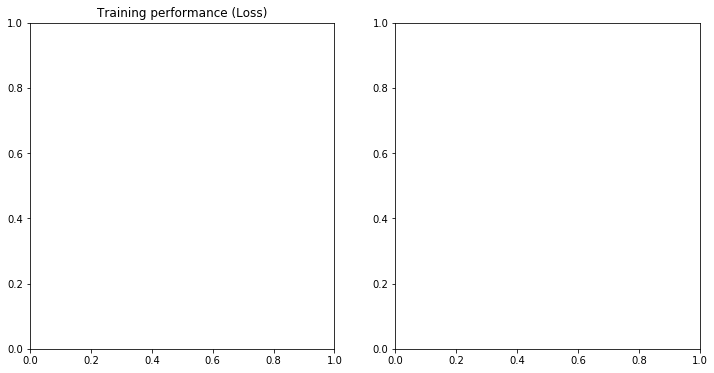

In [31]:
# 学習曲線
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

## 予測の可視化

In [32]:
# 予測値
Y_test_pred = model.predict(X_test)

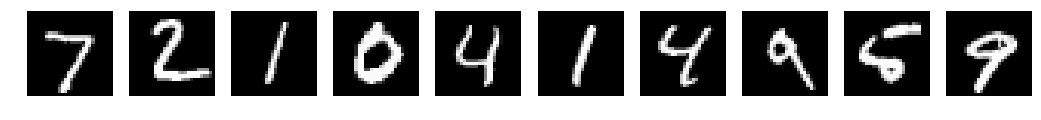

In [33]:
# テストデータの可視化
fig, ax = plt.subplots(1, 10, figsize=(18, 8))

for ii in range(10):
    ax[ii].imshow(X_test[ii].reshape(28, 28), cmap='gray') #iiの値+nでn番目以降のテストデータを出力する．
    ax[ii].axis('off')

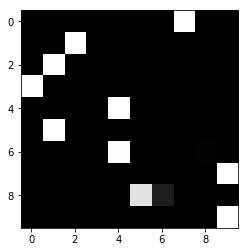

In [34]:
# 予測の可視化
plt.imshow(Y_test_pred[:10], cmap='gray', interpolation='nearest', vmin=0, vmax=1) #Y_test_predの範囲を帰ることで予測の場所を変更できる